# SVM Multiclass Classifier 

## Analysis Plan: 

I plan on using a Support Vector Machine (SVM) for a classification problem. 
Specifically, my target is the accuracy of vaccination information. This data was scraped from Twitter accounts that either posts mis-information  or true information about vaccines. My goal is to accurately classify whether a tweet is accurate or mis-information based on the sentiment of the tweet (positive, negative, or neutral) and the number of favorites and retweets that the specific tweet got. 

In [1]:
# import general libraries 

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
# use seaborn defaults 
import seaborn as sns; sns.set()

In [2]:
# import machine learning libraries 
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [3]:
# load data
twitter = pd.read_csv('https://raw.githubusercontent.com/AnnaWysocki/Twitter-Python-Project/master/ML_data.csv')

We will only using some of these columns so let's subset the dataframe 

In [4]:
sub = ["favorite_count", "retweet_count", "true_indicator", "cat_polarity"]
subsetted_data = twitter[sub]

Our features will be: favorite_count, retweet_count, user_follower_count, cat_polarity (sentiment categories)
Our target will be true_indicator (misinformation vs true information) 

However, the values within our target column are string so let's convert them to numeric 

In [5]:
# Convert y values to integers

convert_to_int = {"positive": 1 , "neutral": 0, "negative": -1}
subsetted_data['cat_polarity'] = [convert_to_int[item] for item in subsetted_data.cat_polarity]

C:\Users\annawy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Now let's split our data set into the training and test dataset

80% of the data will be in the training dataset
and 
20% will be in the testing dataset 

In [10]:
train, test = train_test_split(subsetted_data, test_size = .2)

X_train = train.iloc[:, [0, 1, 3]]
X_test = test.iloc[:, [0, 1, 3]]
y_train = train.iloc[:, 2]
y_test = test.iloc[:, 2]

Now that we've split the data, we can visualize our features and target to get a better idea of what we are working with 

Text(0,0.5,'Retweets')

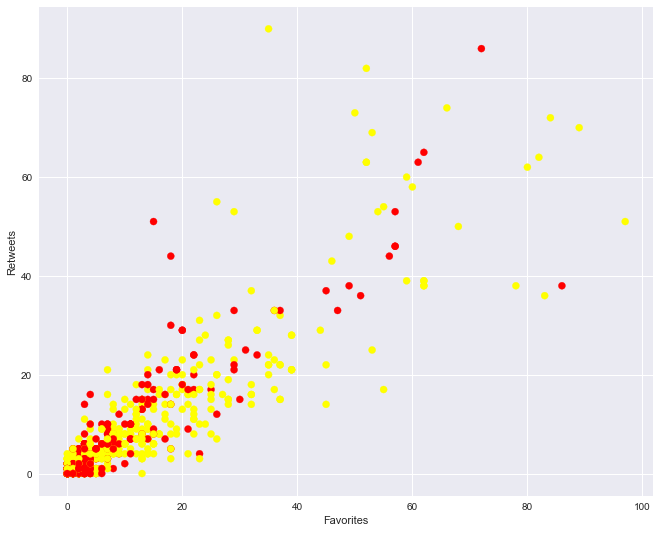

In [11]:
#plot of only two of the features 
fig = plt.figure(figsize=(11,9))
plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_train, s=50, cmap='autumn')
plt.xlabel('Favorites')
plt.ylabel('Retweets')


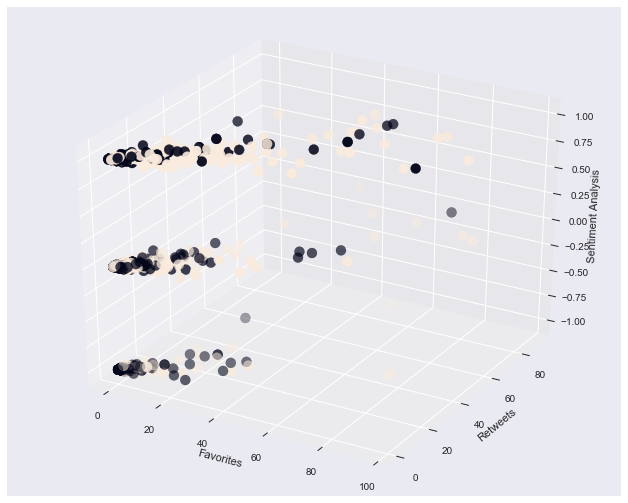

In [12]:
# If we want to visualize all three features, we have to create a 3D plot, which is a bit harder to interpet

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(11,9))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], X_train.iloc[:, 2], c = y_train, marker = 'o', s=100)
ax.set_xlabel('Favorites')
ax.set_ylabel('Retweets')
ax.set_zlabel('Sentiment Analysis')
plt.show()

When running a linear SVM, it's important to scale the features 

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

# Rescale Predictors

x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.fit_transform(X_test)

For this first model, I'm leaving all the parameters at their default

In [16]:
model_default = SVC(kernel = 'linear', C = 1.0).fit(x_train_scaled, y_train)
model_default

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [19]:
accuracy = model_default.score(x_test_scaled, y_test)
accuracy

0.6037735849056604


Model fit is not great.
This means that our training model is only 60.3% accurate at categorizing in our test data. 

We may be able to increase prediction by doing a grid search to select better parameters for the SVM model. 

As seen in earlier plots, there is overlap within our data. Softening the margins may help. This means that our models allows some of the points to creep into the margins if it allows for better fit. A soft-margin classifier may be superior if your data is not perfectly linearly separable. Also hard-margins are more likely to overfit.

Margin softness can be controlled through the parameter C - with smaller C = a softer margin

Another parameter that we can look at is gamma. Gamma controls the curvature of the hyperplane with larger gammas increasing the curvature. 

In [25]:
from sklearn import svm, grid_search
from sklearn.model_selection import GridSearchCV

In [26]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10, 15, 20]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [28]:
svc_param_selection(x_train_scaled, y_train, 5)

{'C': 20, 'gamma': 0.01}

In [29]:
model_selectparam = SVC(kernel = 'linear', C = 20, gamma = .01).fit(x_train_scaled, y_train)
model_selectparam.score(X_test, y_test)

0.6273584905660378

The grid search returned a larger C than the default indicating that there was better model fit when the margins were hardened. Running the model with the returned parameters, increased prediction by 2% in the test dataset. 


We can get a better idea of our model's performance by using the classification report. This report lists recovery statsitics label by label. 

In [31]:
target_names= ["True Information", "Mis-information"]

from sklearn.metrics import classification_report

y_true, y_pred= y_test, model_selectparam .predict(X_test)
print(classification_report(y_true, y_pred,
                           target_names= target_names))
print()

                  precision    recall  f1-score   support

True Information       0.69      0.29      0.41        94
 Mis-information       0.61      0.90      0.73       118

     avg / total       0.65      0.63      0.59       212




We can also look at the confusion matrix to get a better idea of which labels are more likely to be confused by the estimator 

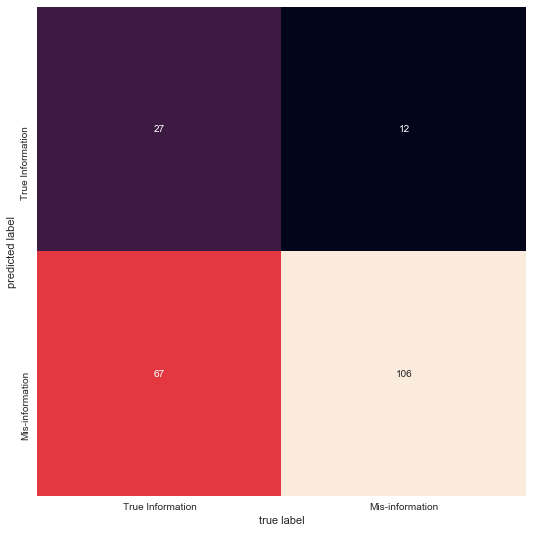

In [32]:
from sklearn.metrics import confusion_matrix
fig = plt.figure(figsize=(11,9))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Based on this it seems like mis-information is reliably being predicted as mis-information. However, true information is not being reliably predicted. 